In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization library 
sns.set()

import re # regular expressions
import string
from wordcloud import WordCloud
from collections import Counter

import warnings # warnings are not errors 
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix,  plot_roc #Receiver Operating Characteristic (ROC) curves

label 0 ---> not depressed
label 1 ---> depressed

In [15]:
data = pd.read_excel('dataset.xlsx')
data.head(2)

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0


In [16]:
data.shape

(6982, 2)

In [17]:
data.isnull().sum() 

text     10
label     2
dtype: int64

In [18]:
data = data.dropna(how='any')

In [28]:
data.shape

(6970, 2)

In [29]:
data['label'].value_counts()

label
0.0    6240
1.0     730
Name: count, dtype: int64

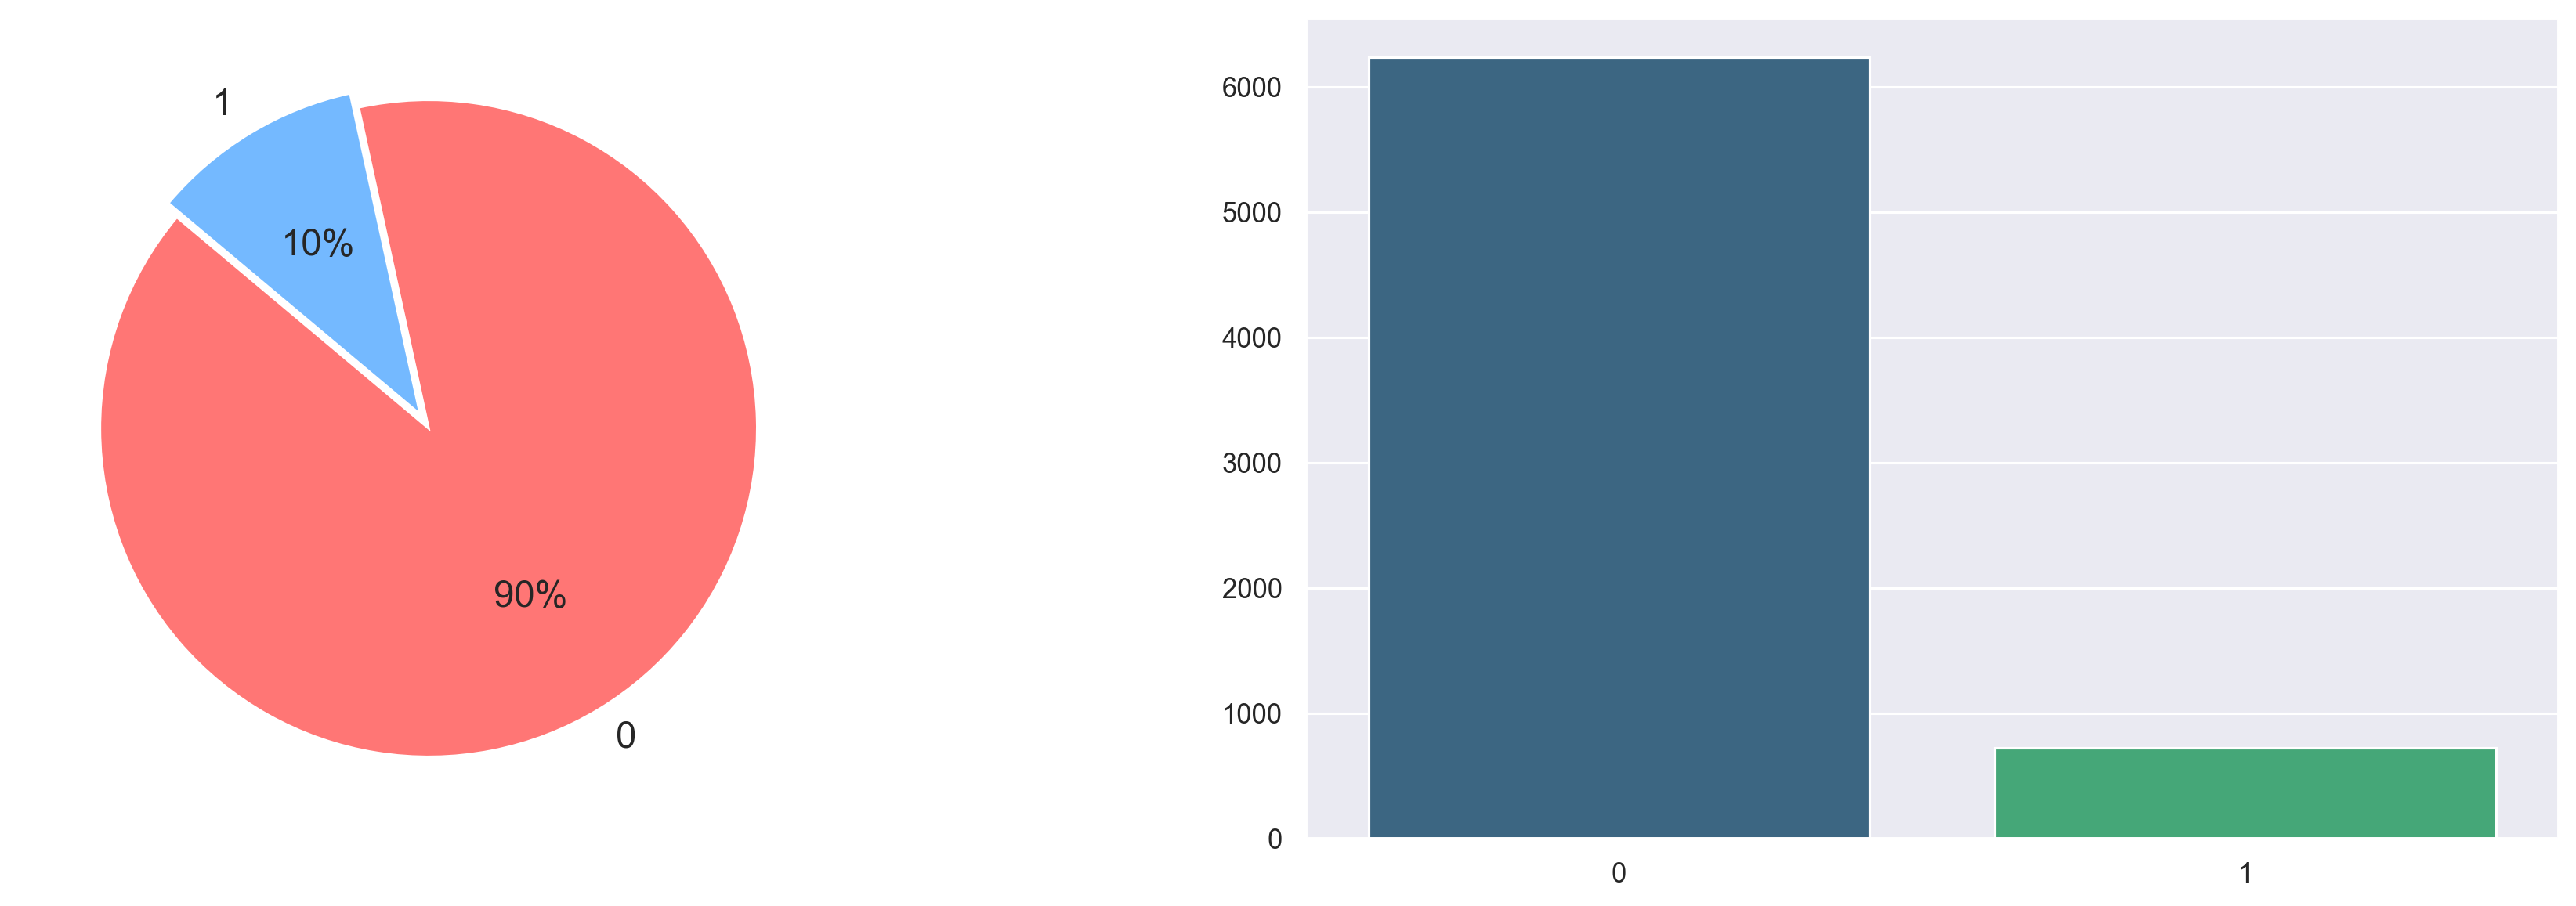

In [26]:
labels = [0, 1]
sizes = [6240, 730]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227) #"Dots Per Inch".
plt.subplot(1,2,1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1,2,2)
sns.barplot(x=labels, y=sizes, palette='viridis')

plt.show()

feature engineering

In [30]:
data.head(2)

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0


In [31]:
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))
data['Total Words'] 

0        3
1       10
2       14
3       11
4       14
        ..
6977     5
6978    11
6979     2
6980    18
6981     5
Name: Total Words, Length: 6970, dtype: int64

In [35]:
def count_total_chars(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data['text'].apply(count_total_chars)

In [36]:
data['Total Chars'] 

0        8
1       55
2       65
3       51
4       59
        ..
6977    29
6978    82
6979     8
6980    79
6981    14
Name: Total Chars, Length: 6970, dtype: int64

In [37]:
data.head(2)

,text,label,Total Words,Total Chars
0,oh my gosh,1.0,3,8
1,"trouble sleeping, confused mind, restless hear...",1.0,10,55


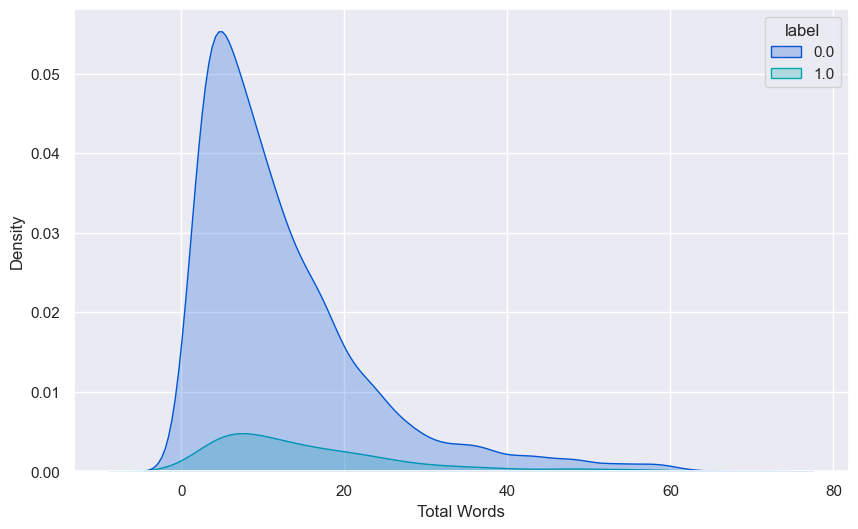

In [39]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue = data['label'], palette = 'winter', shade = True)
plt.show()

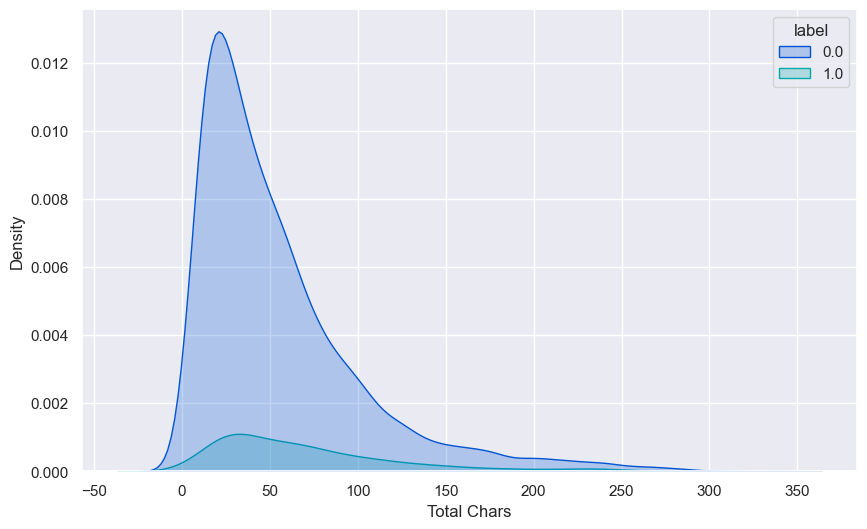

In [40]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue = data['label'], palette = 'winter', shade = True)
plt.show()

text preprocessing

In [41]:
# convert text in lowercase
def convert_to_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_to_lowercase)

In [42]:
# remove if any url is present
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

In [44]:
# remove punctuation
exclude = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punctuation)

In [45]:
# remove stopwords
def remove_stopwords(text):
    new_list=[]
    words = word_tokenize(text)
    stop_words = stopwords.words('english')
    for word in words:
        if word not in stop_words:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

In [46]:
# loving lover --> stemmming --> love
def perforn_stemming(text):
    stemmer = PorterStemmer()
    new_list=[]
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perforn_stemming)

In [47]:
data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [48]:
data.head(2)

,text,label,Total Words,Total Chars,Total Words After Transformation
0,oh gosh,1.0,3,8,0.693147
1,troubl sleep confus mind restless heart tune,1.0,10,55,1.945910


visualization

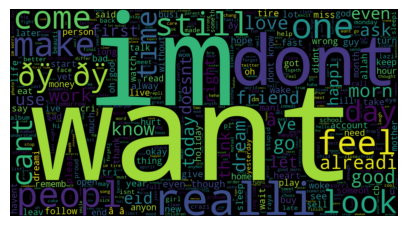

In [56]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (5, 8))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500, background_color="black", colormap='viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [57]:
# text = " ".join(data[data['label'] == 0]['text'])
# plt.figure(figsize = (10, 8))
# wordcloud = WordCloud(max_words=600, height= 800, width = 1500, background_color="pink", colormap='viridis').generate(text)
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

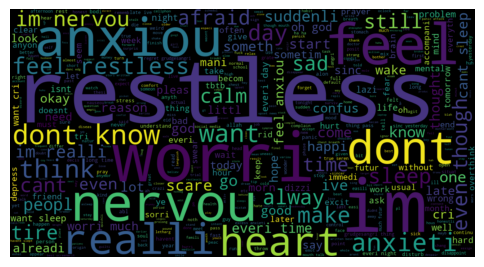

In [58]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (6, 8))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500, background_color="black", colormap='viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

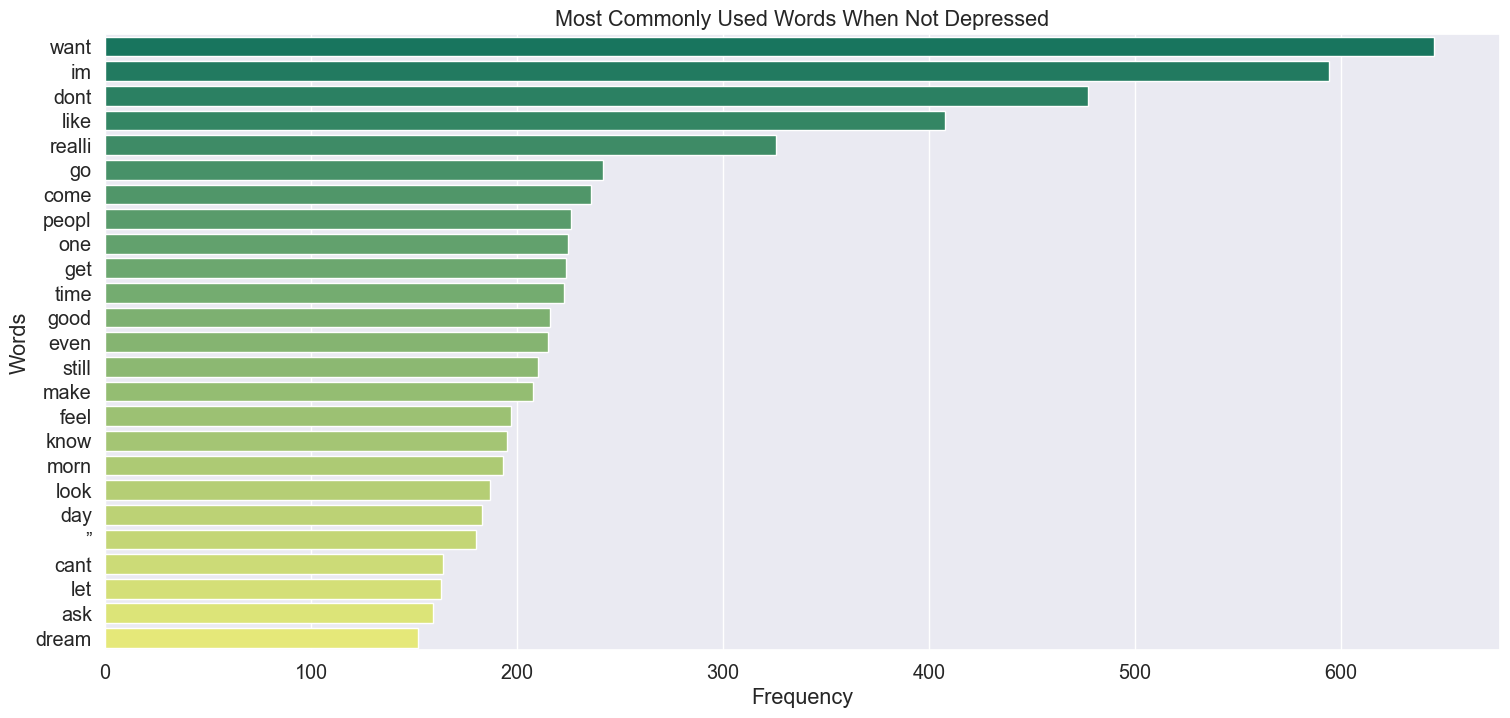

In [59]:
# Most Commonly Used Words When Not Depressed
all_nodep_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_nodep_words.append(word)

df = pd.DataFrame(Counter(all_nodep_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale=1.3)
plt.figure(figsize=(18, 8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette='summer')
plt.title("Most Commonly Used Words When Not Depressed")
plt.xlabel('Frequency')
plt.ylabel("Words")
plt.show()

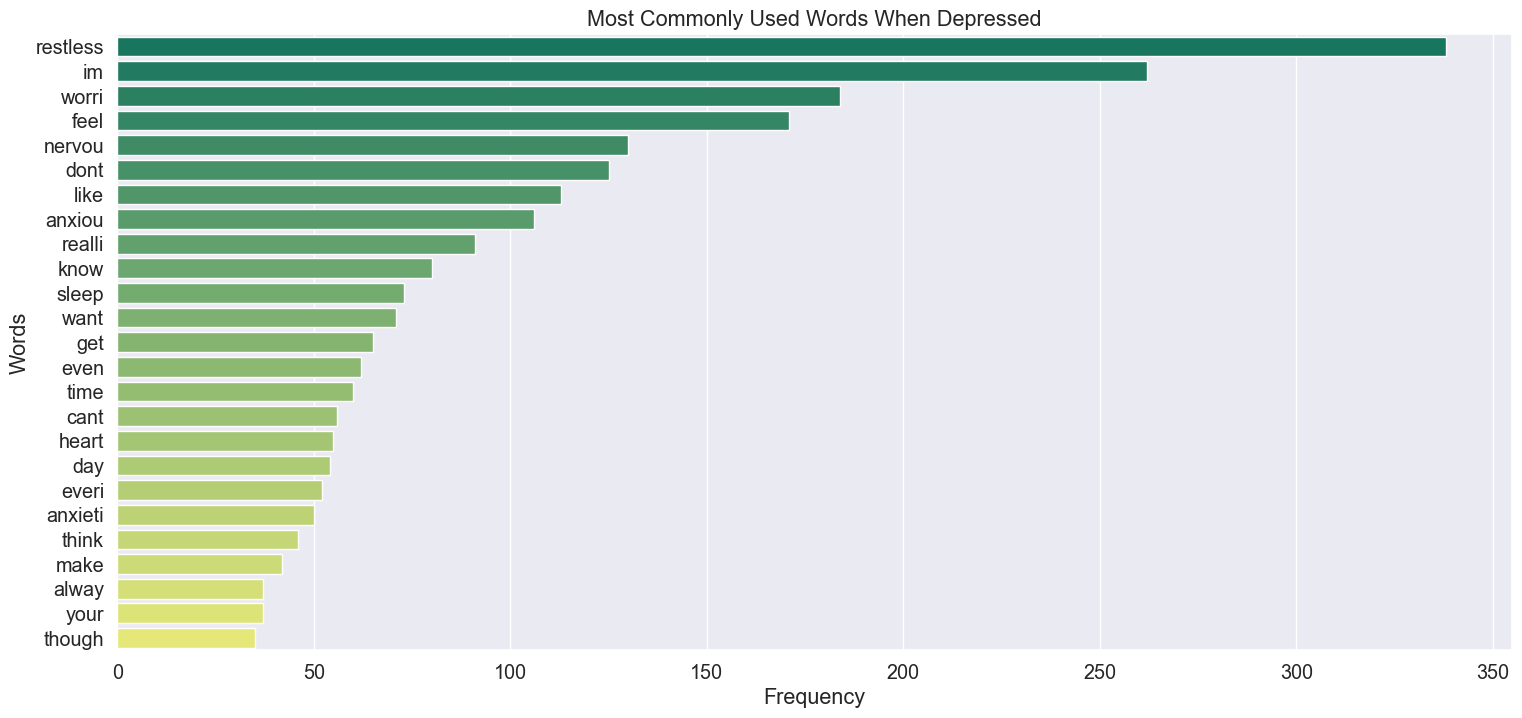

In [60]:
# Most Commonly Used Words When Depressed
all_dep_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_dep_words.append(word)

df = pd.DataFrame(Counter(all_dep_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale=1.3)
plt.figure(figsize=(18, 8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette='summer')
plt.title("Most Commonly Used Words When Depressed")
plt.xlabel('Frequency')
plt.ylabel("Words")
plt.show()

vectorization

In [63]:
x = data['text']
y = data['label'].values

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify=y)

In [67]:
tfidf = TfidfVectorizer(max_features=2500, min_df=2)
x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()

In [70]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Modeling 

In [74]:
# 1.naive bayes 

def train_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale = 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25, 8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax=ax[0], cmap='YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax=ax[1], plot_macro=False, plot_micro=False,cmap='summer')

Accuracy of the model: 0.934
Precision Score of the model: 1.0
Recall Score of the model: 0.37


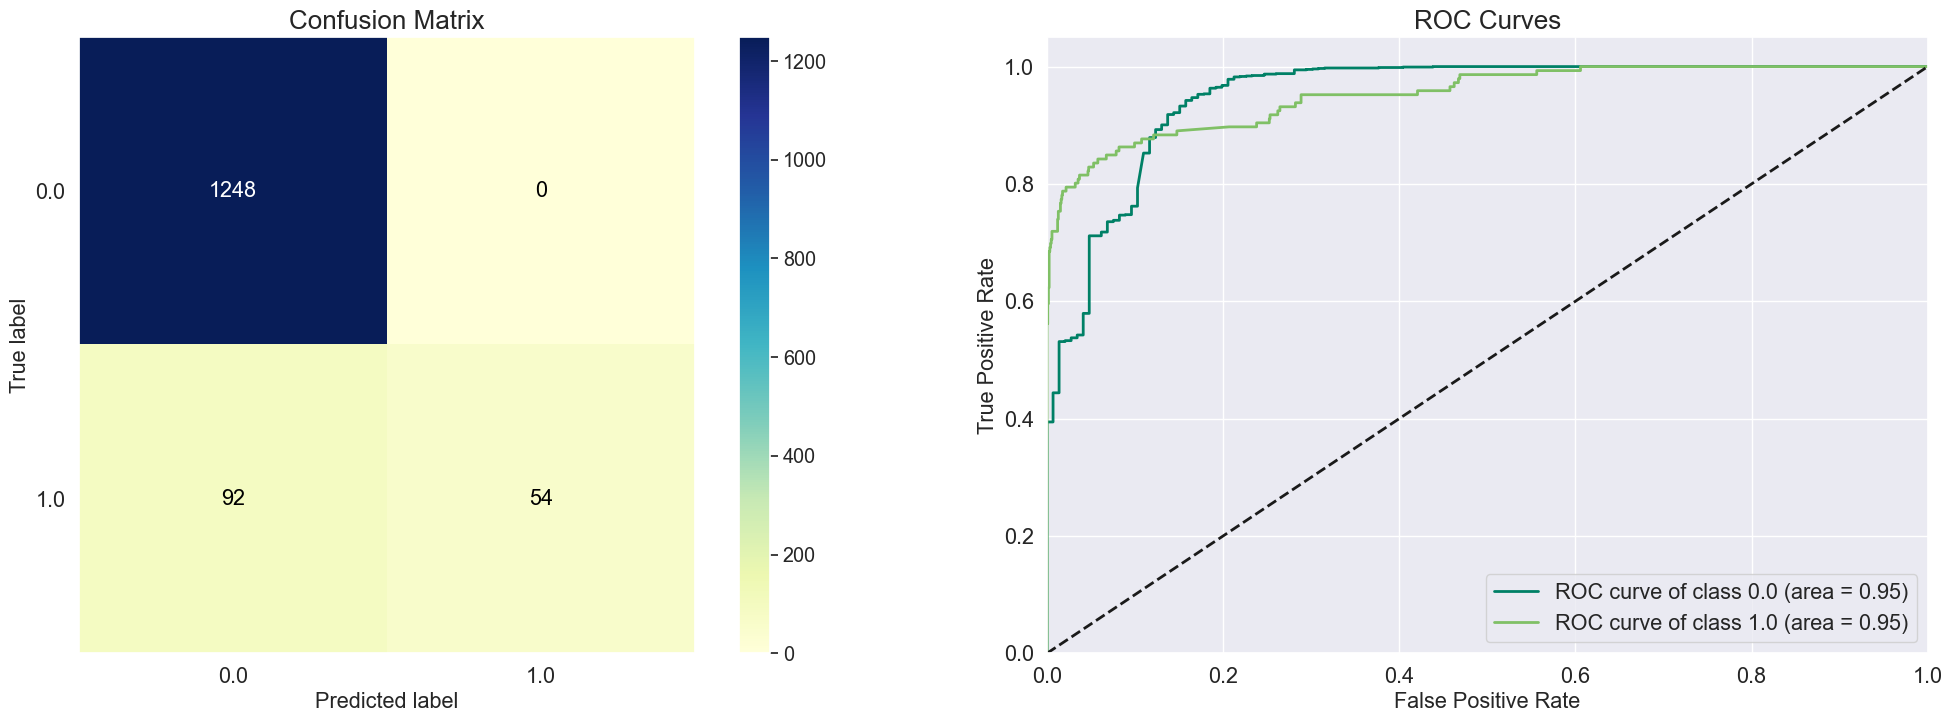

In [75]:
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.989
Precision Score of the model: 0.978
Recall Score of the model: 0.918


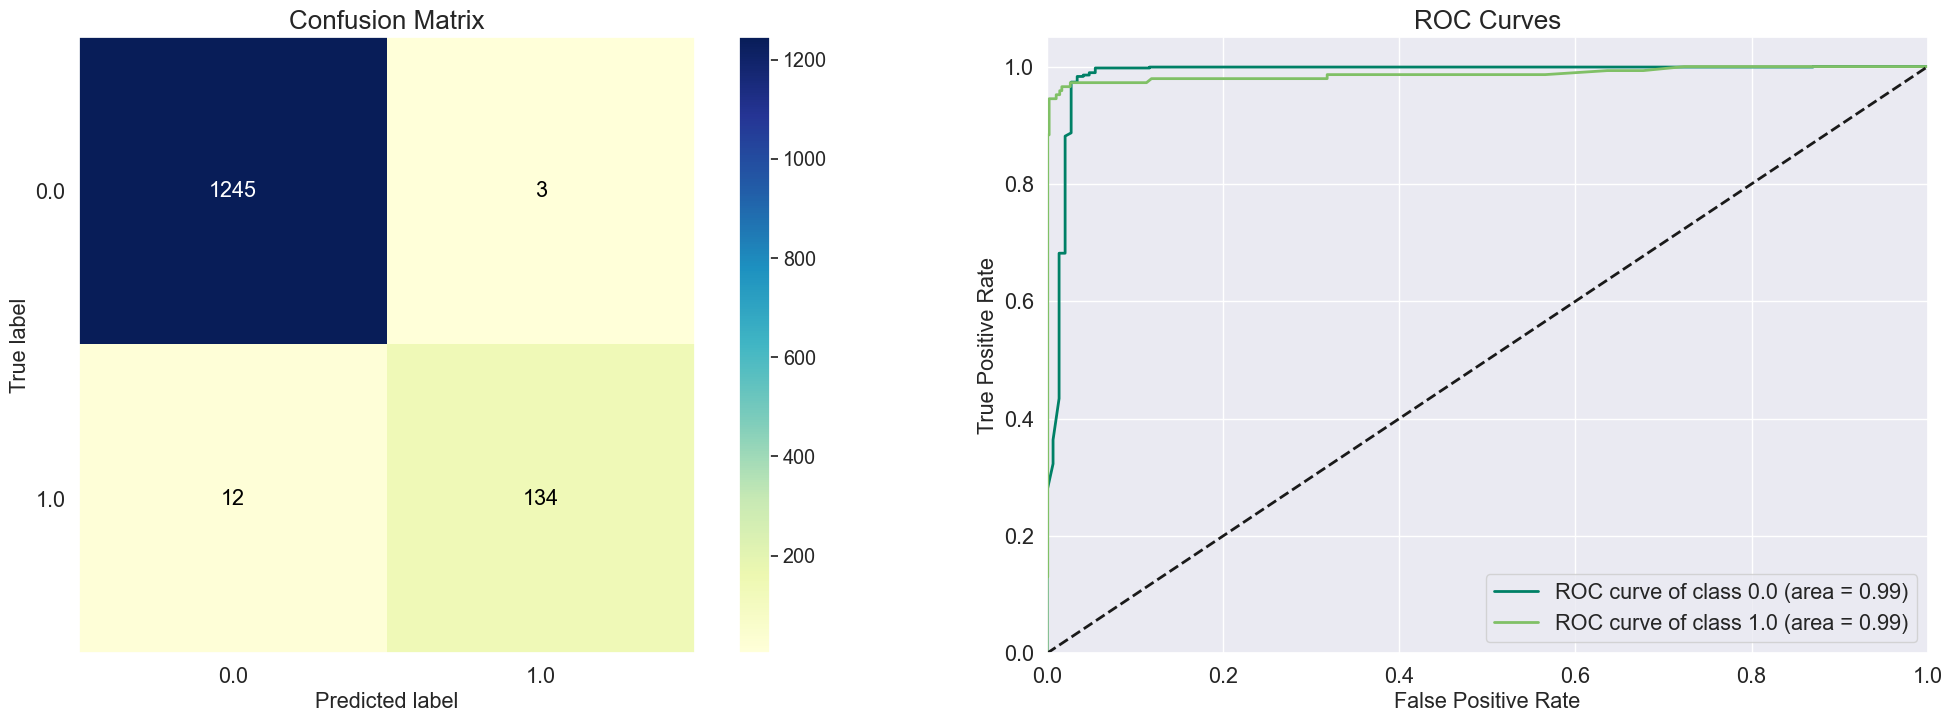

In [76]:
# 2. random forest
# n_estimators ---> the number of decision trees in the random forest ensemble
rf = RandomForestClassifier(n_estimators=300)
train_model(rf)

In [77]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
gnb = GaussianNB()
bnb = BernoulliNB()

Accuracy of the model: 0.673
Precision Score of the model: 0.185
Recall Score of the model: 0.623


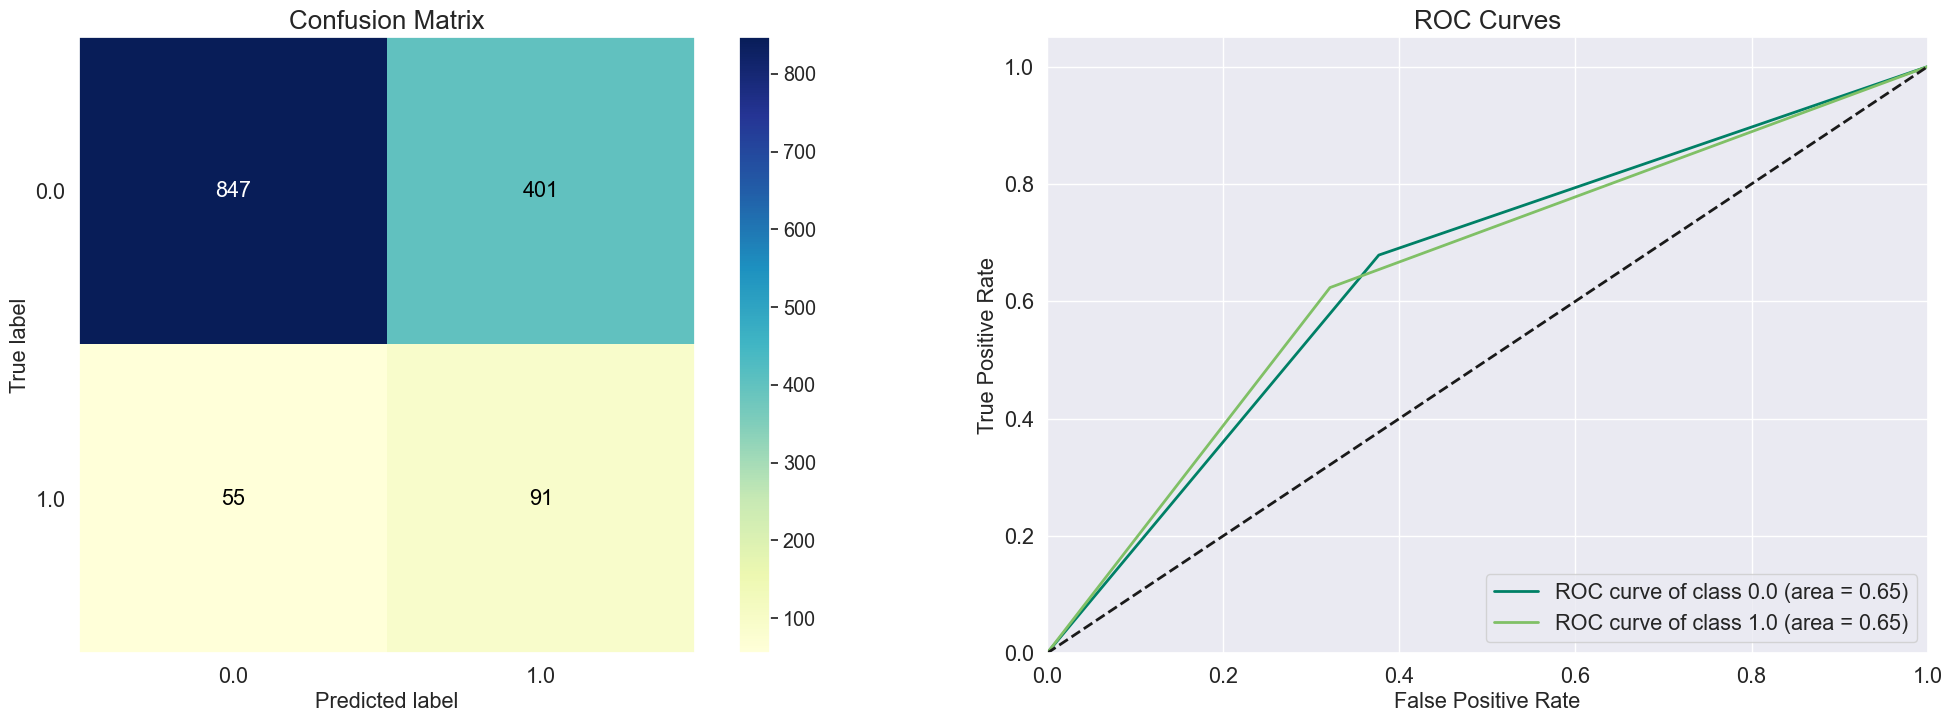

In [78]:
train_model(gnb)

Accuracy of the model: 0.963
Precision Score of the model: 0.873
Recall Score of the model: 0.753


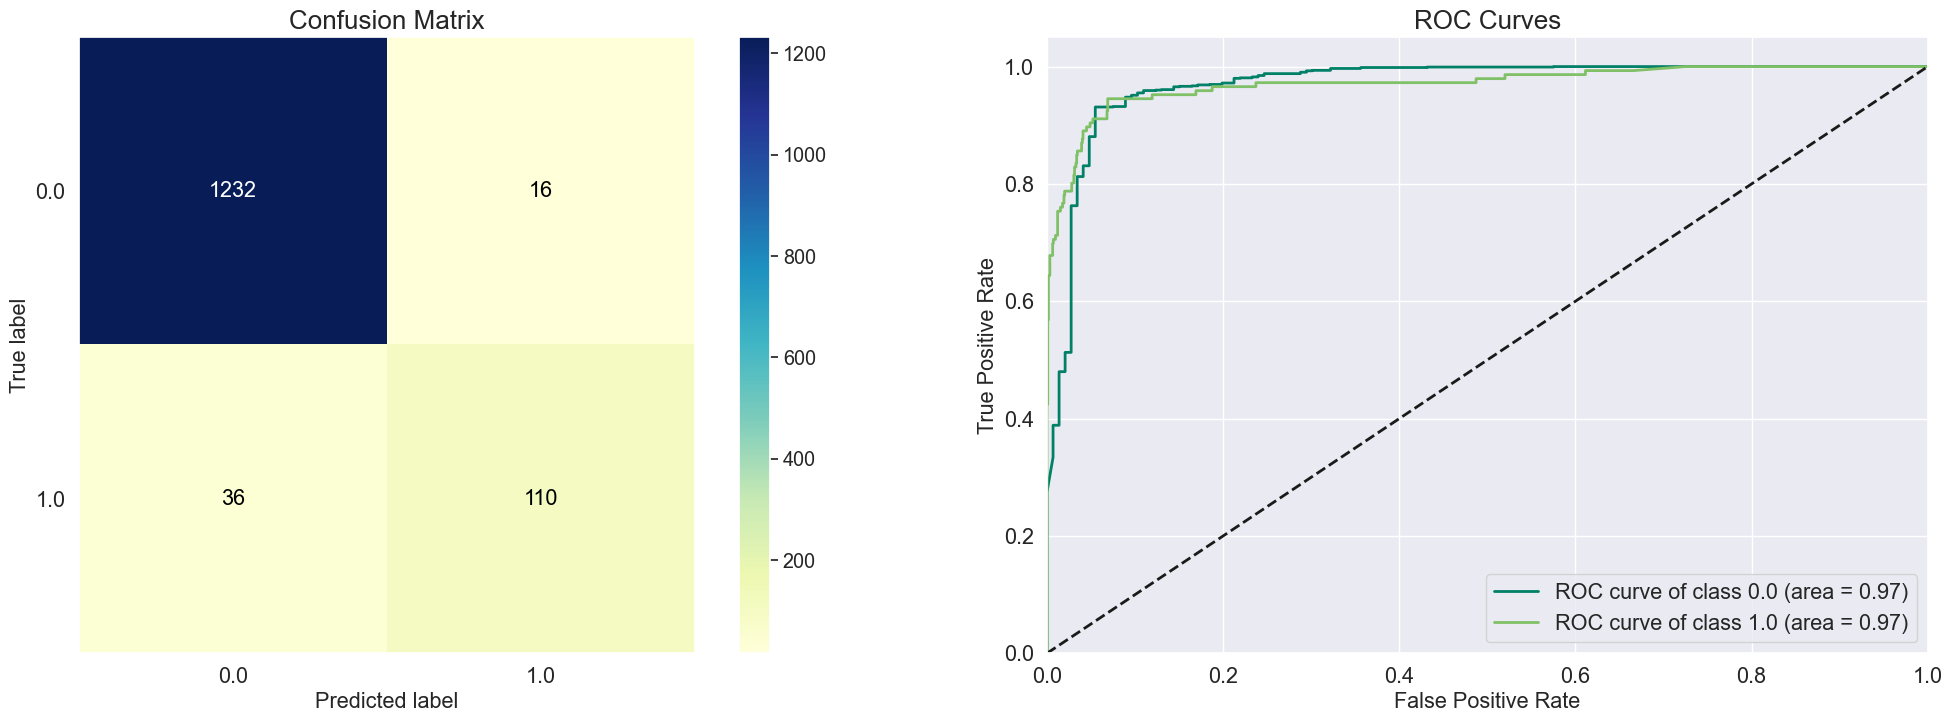

In [79]:
train_model(bnb)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [81]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5) 
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)
bc = BaggingClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(n_estimators=50, random_state=42)

In [86]:
clfs = {
    # 'SVC' : svc,
    'KN' : knc,
    'DT' : dtc,
    'LR' : lrc,
    'RF' : rfc,
    'AdaBoost' : abc,
    'BgC' : bc,
    'ETC' : etc,
    'GBDT' : gbdt,
    'xgb' : xgb
 }

Name :- KN
Accuracy of the model: 0.925
Precision Score of the model: 0.938
Recall Score of the model: 0.308
Name :- DT
Accuracy of the model: 0.994
Precision Score of the model: 0.993
Recall Score of the model: 0.952
Name :- LR
Accuracy of the model: 0.983
Precision Score of the model: 0.992
Recall Score of the model: 0.842
Name :- RF
Accuracy of the model: 0.989
Precision Score of the model: 0.978
Recall Score of the model: 0.911
Name :- AdaBoost
Accuracy of the model: 0.985
Precision Score of the model: 0.963
Recall Score of the model: 0.89
Name :- BgC
Accuracy of the model: 0.993
Precision Score of the model: 0.979
Recall Score of the model: 0.952
Name :- ETC
Accuracy of the model: 0.972
Precision Score of the model: 0.965
Recall Score of the model: 0.76
Name :- GBDT
Accuracy of the model: 0.991
Precision Score of the model: 0.979
Recall Score of the model: 0.938
Name :- xgb
Accuracy of the model: 0.991
Precision Score of the model: 0.993
Recall Score of the model: 0.925


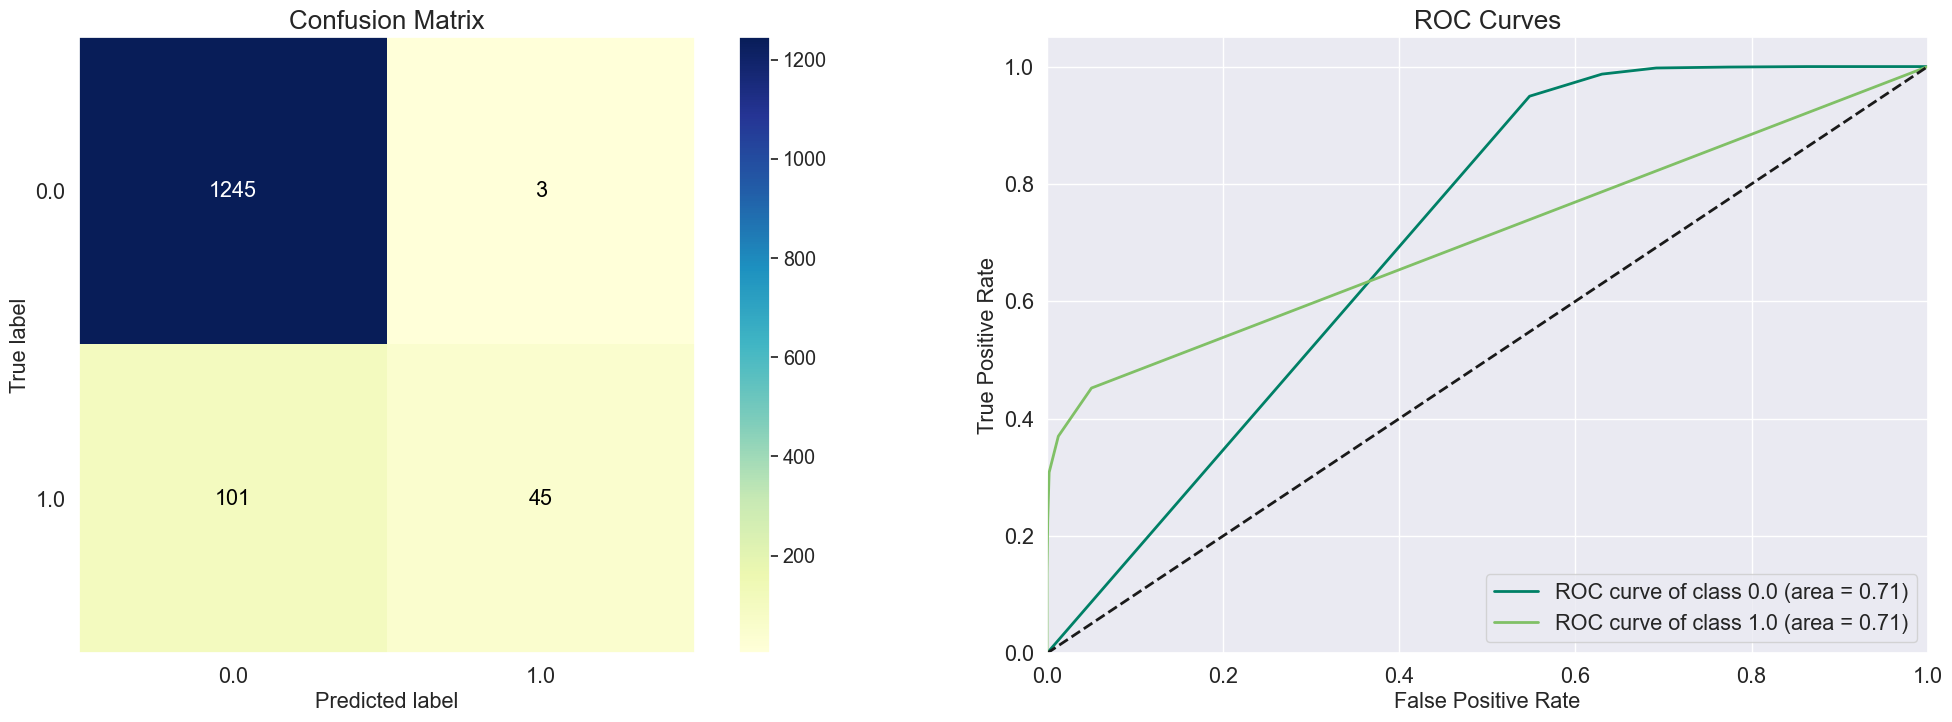

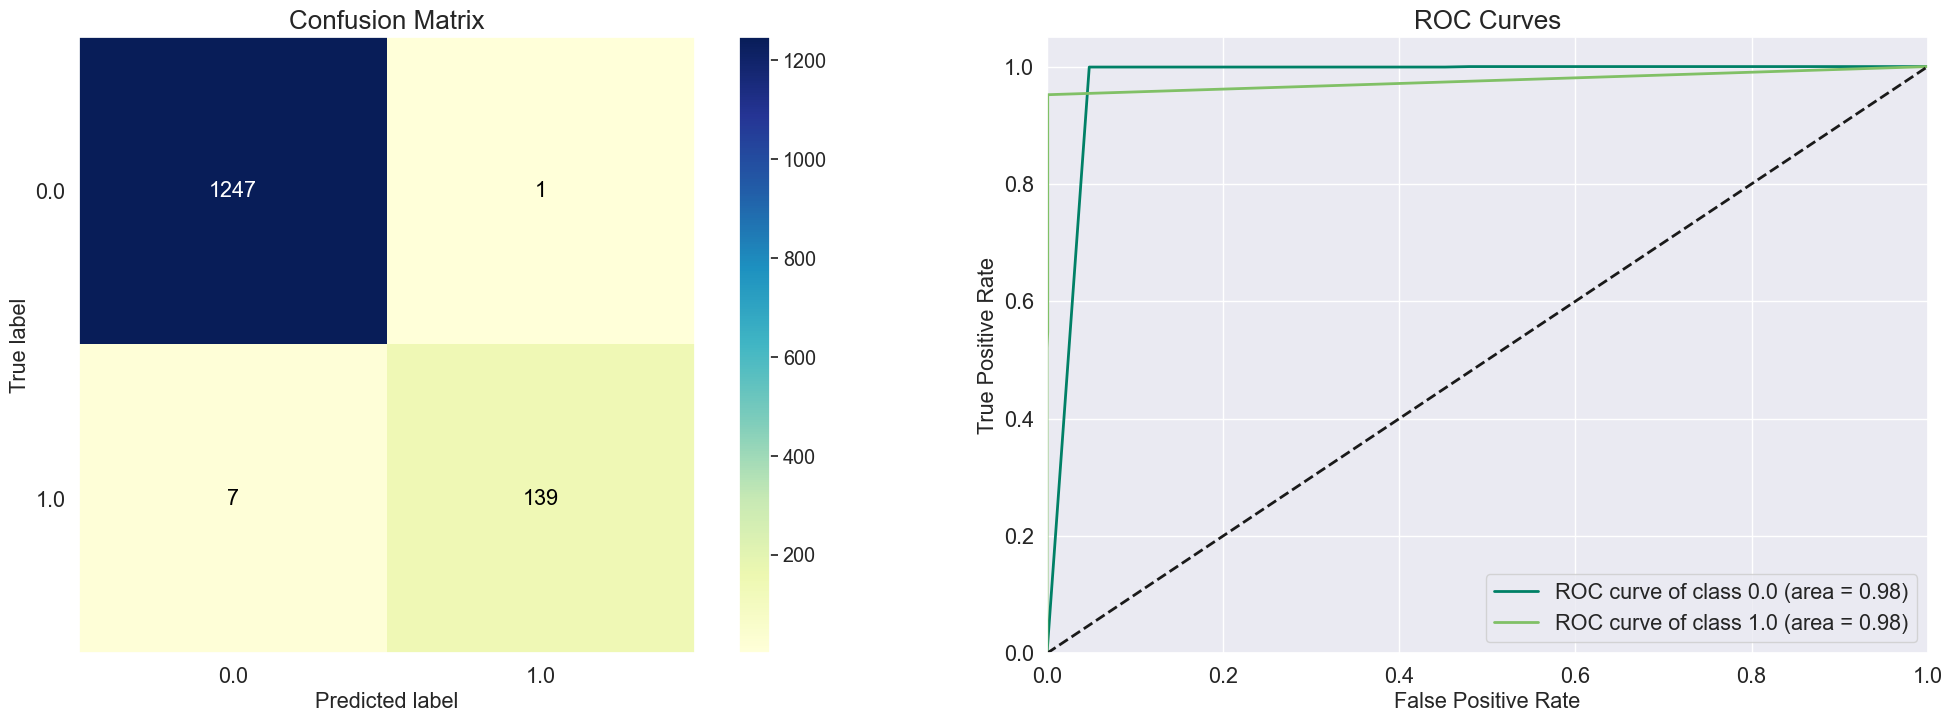

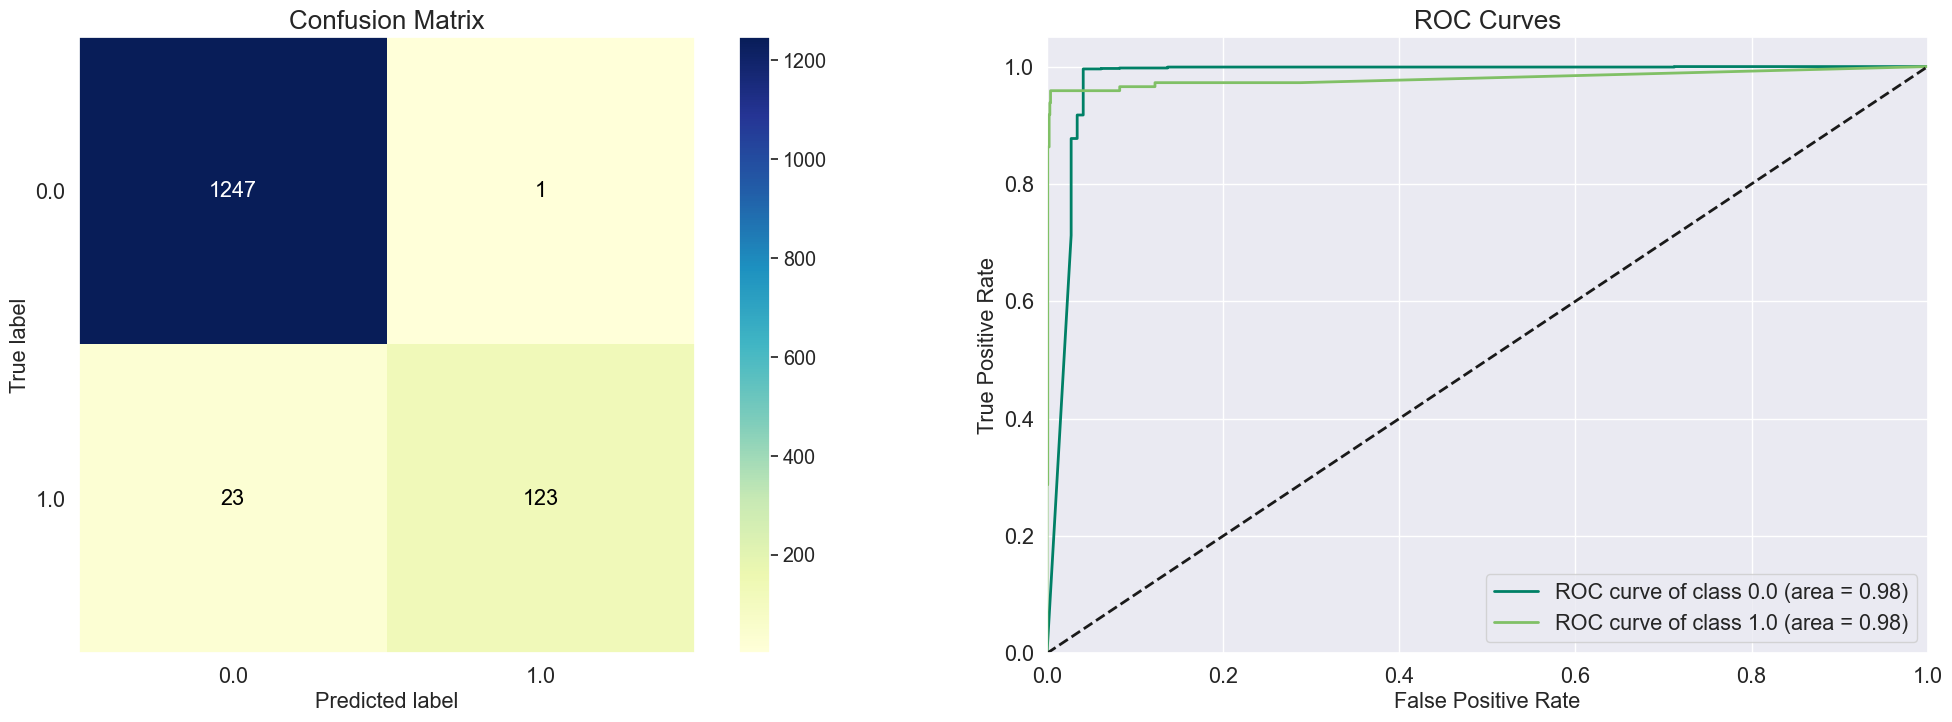

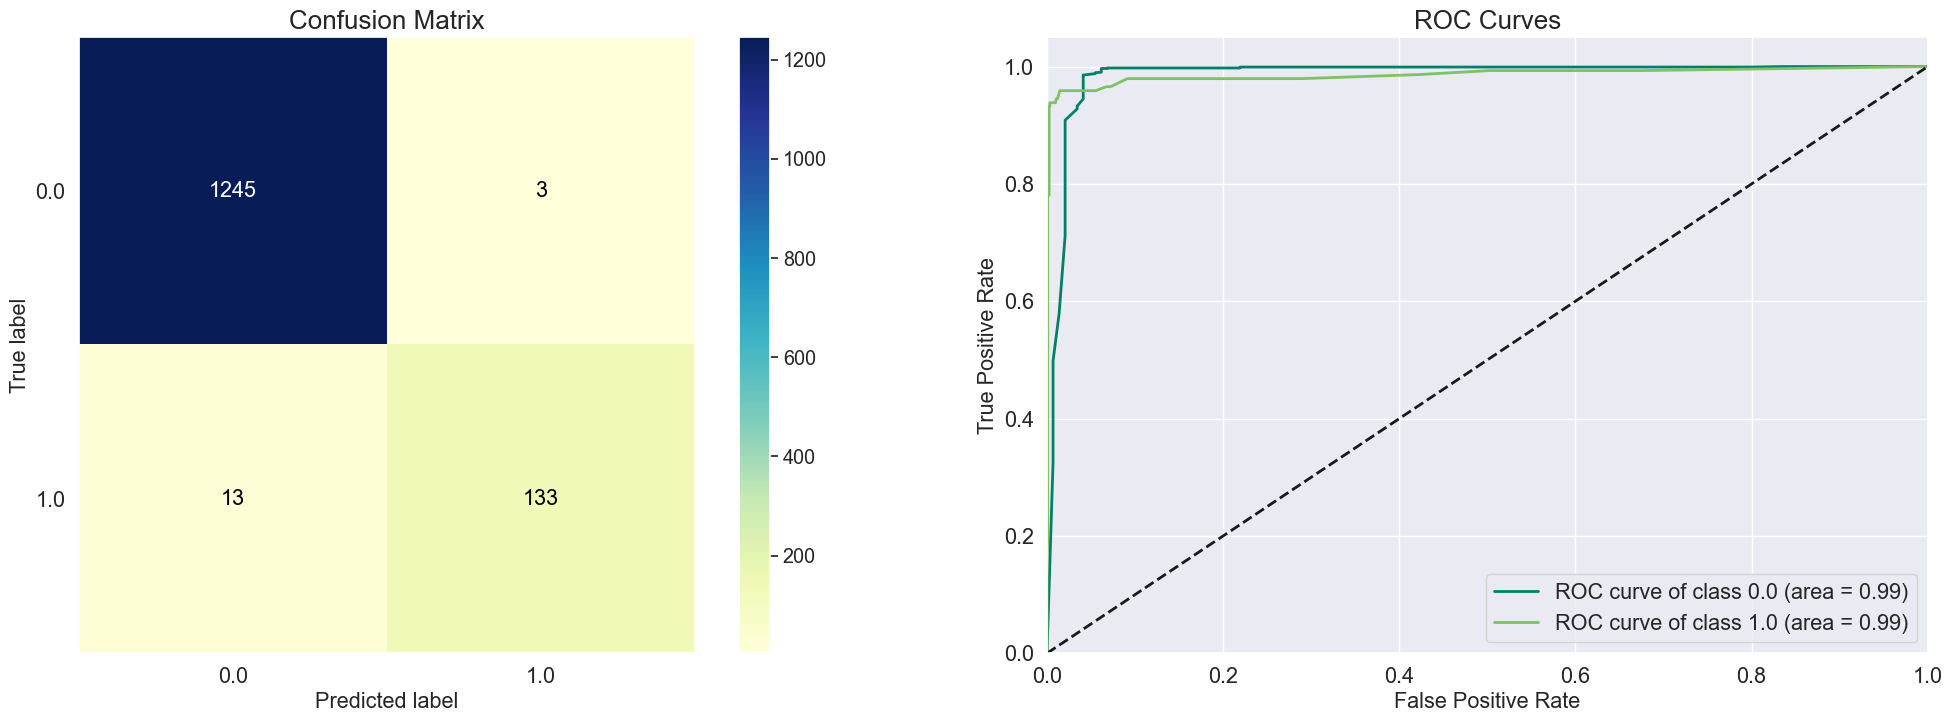

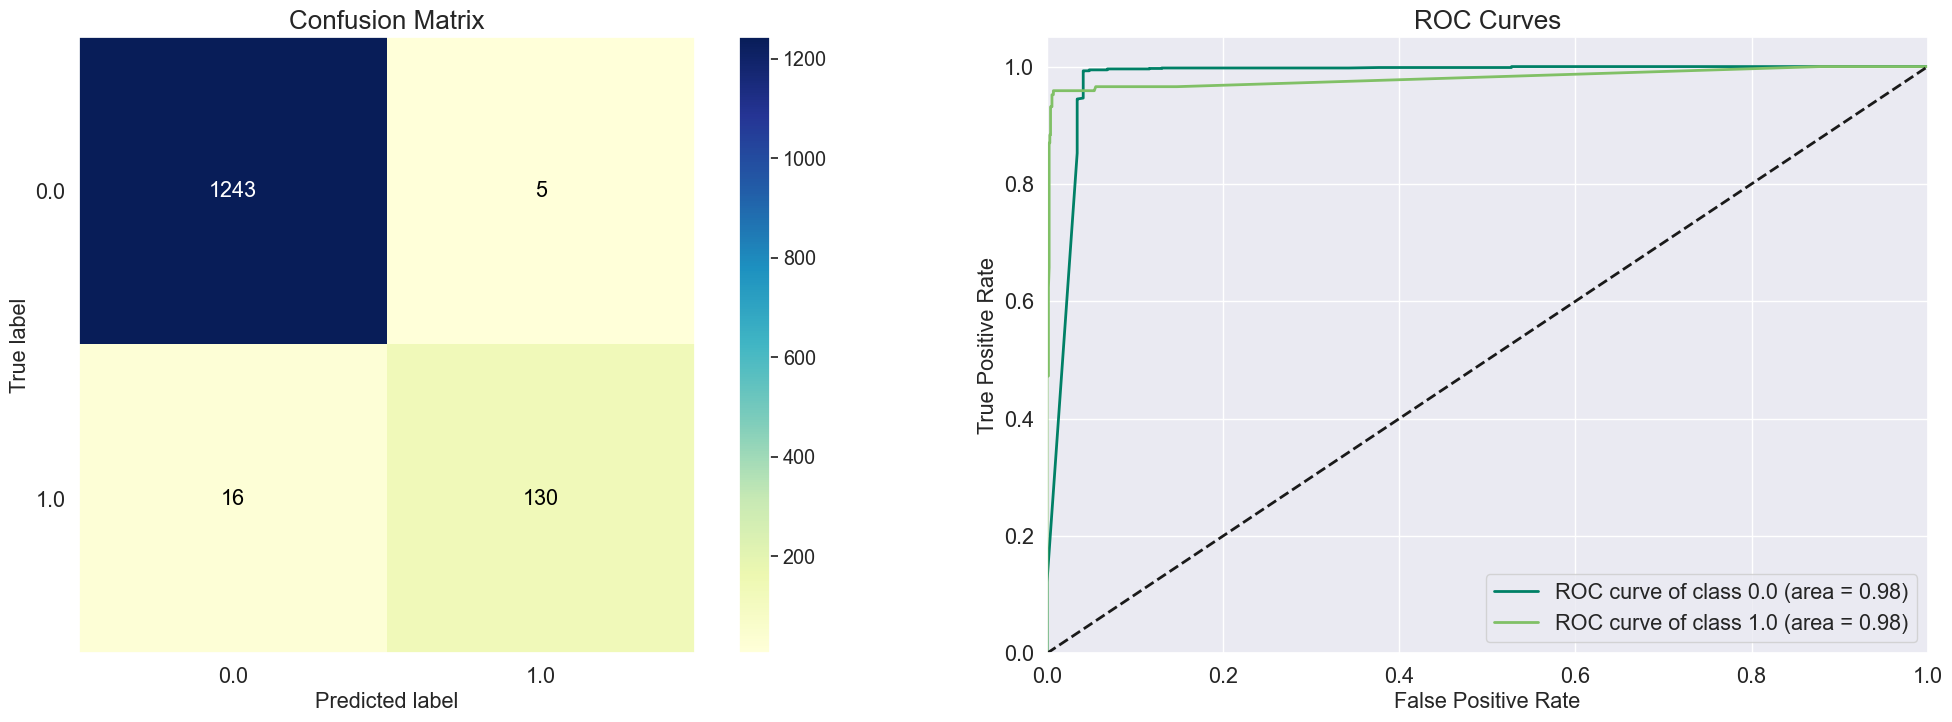

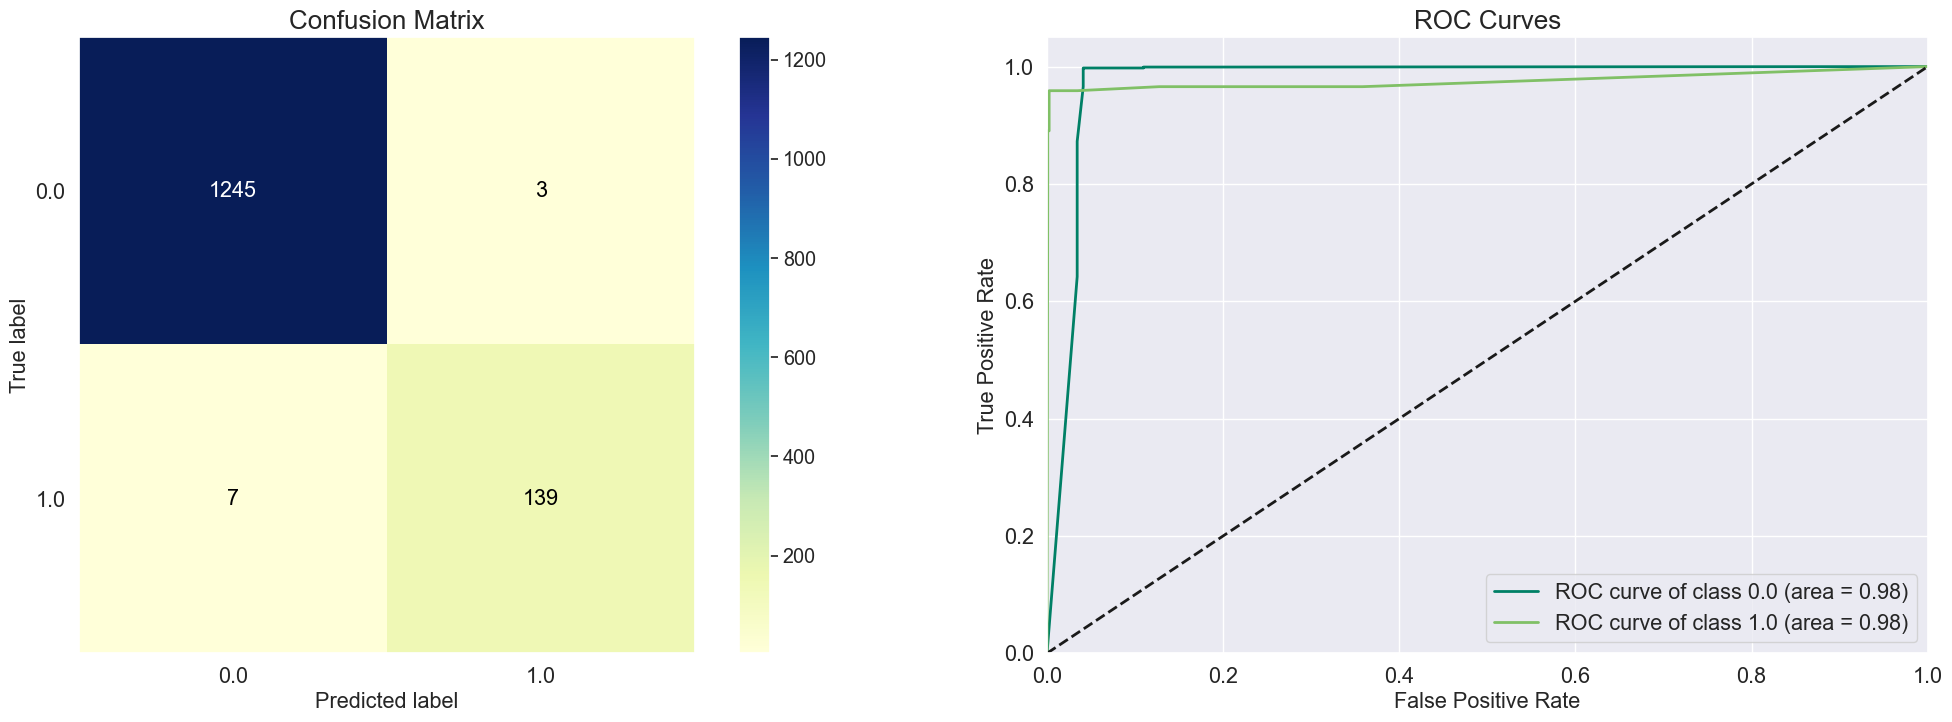

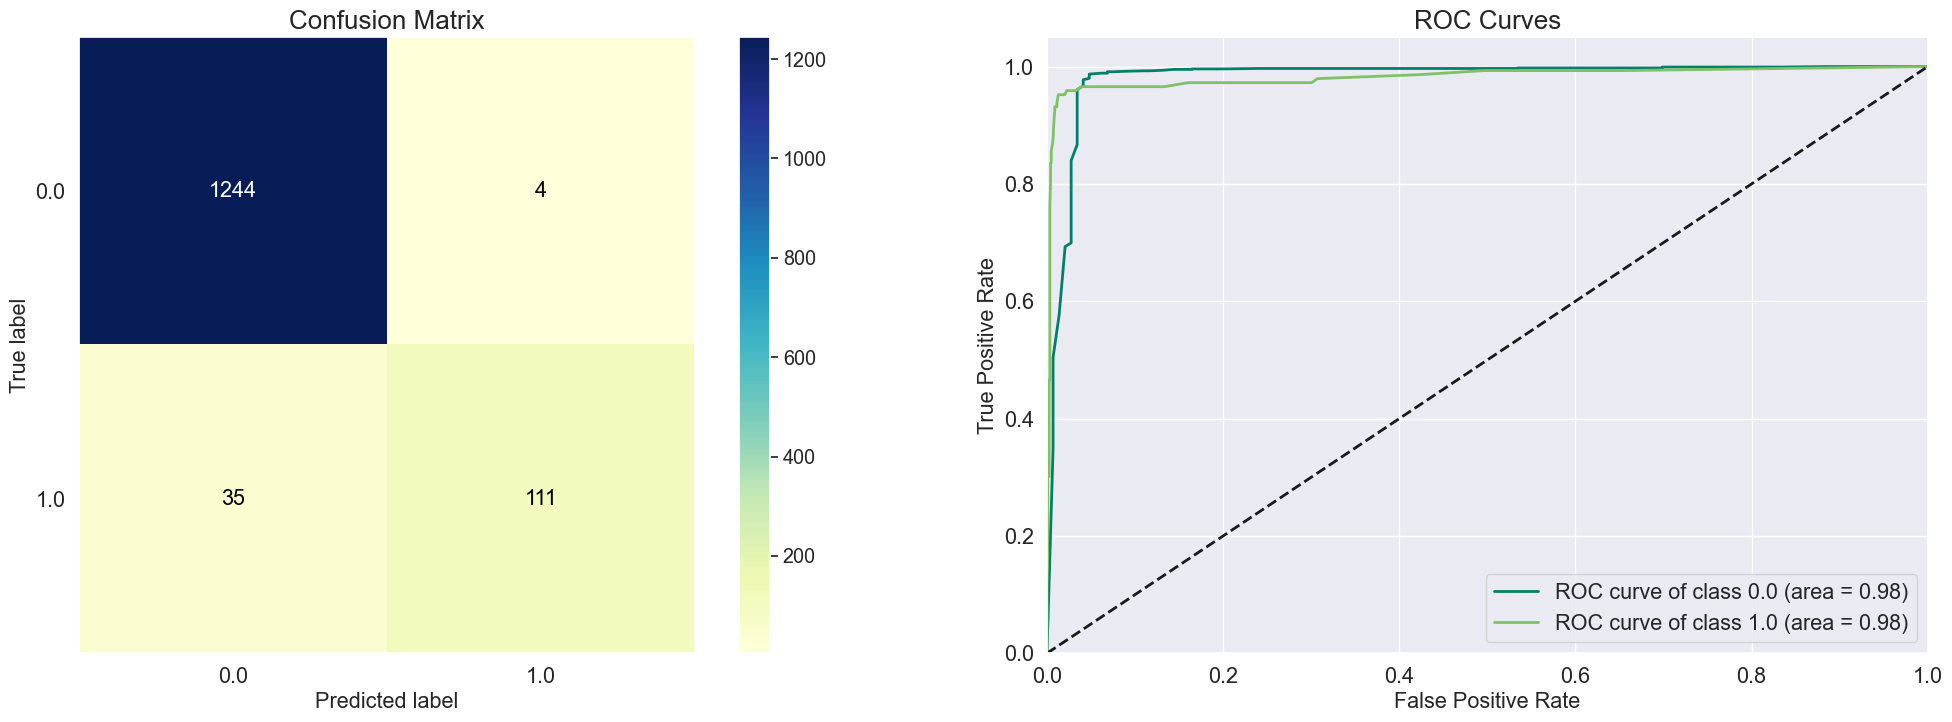

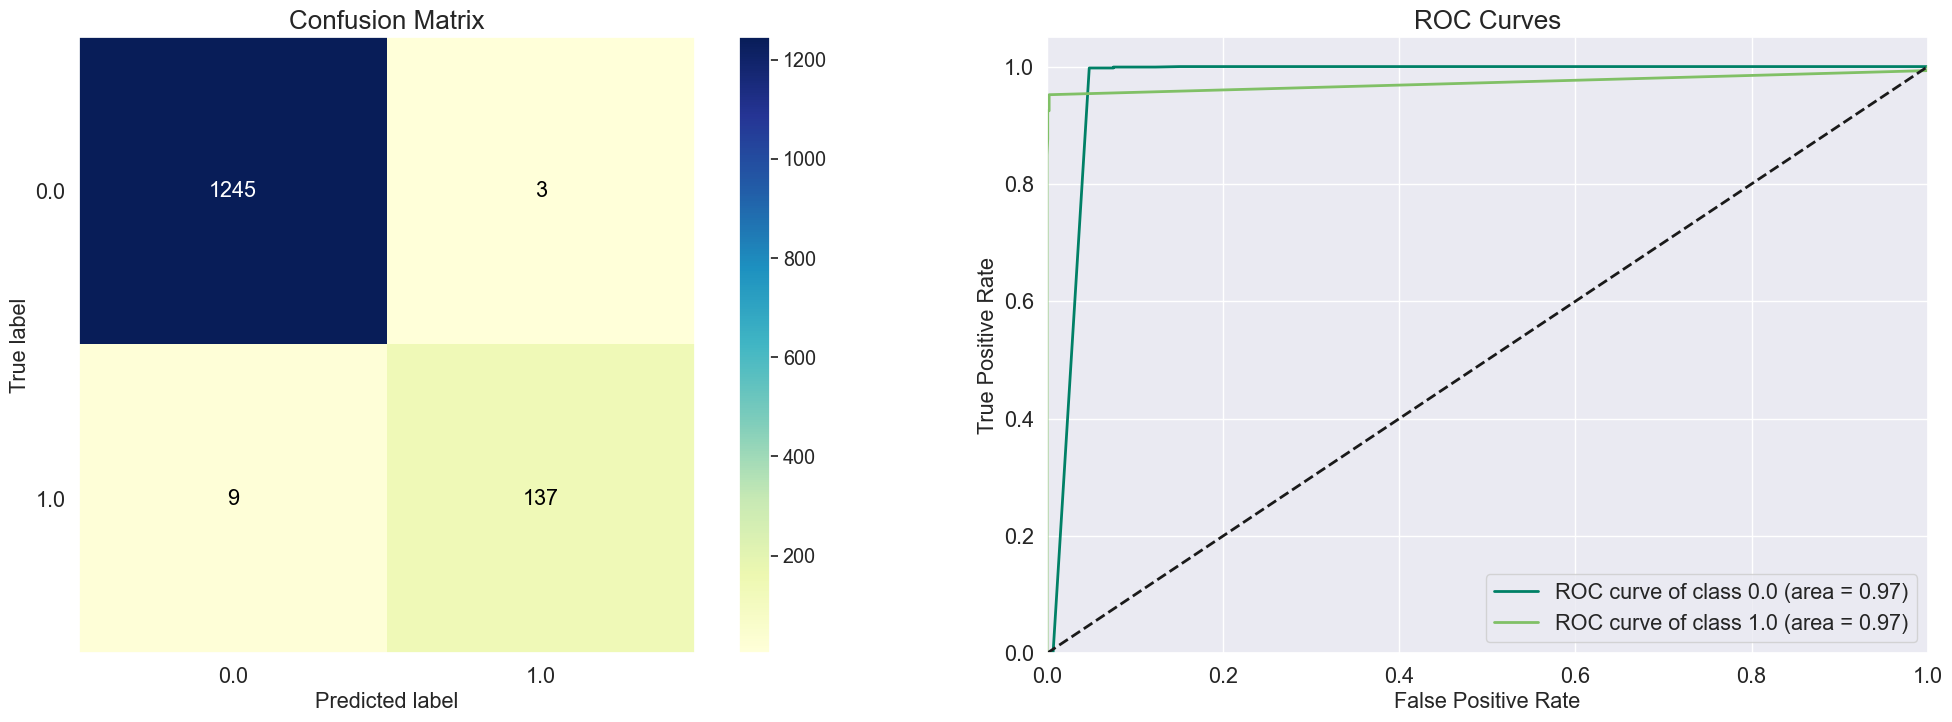

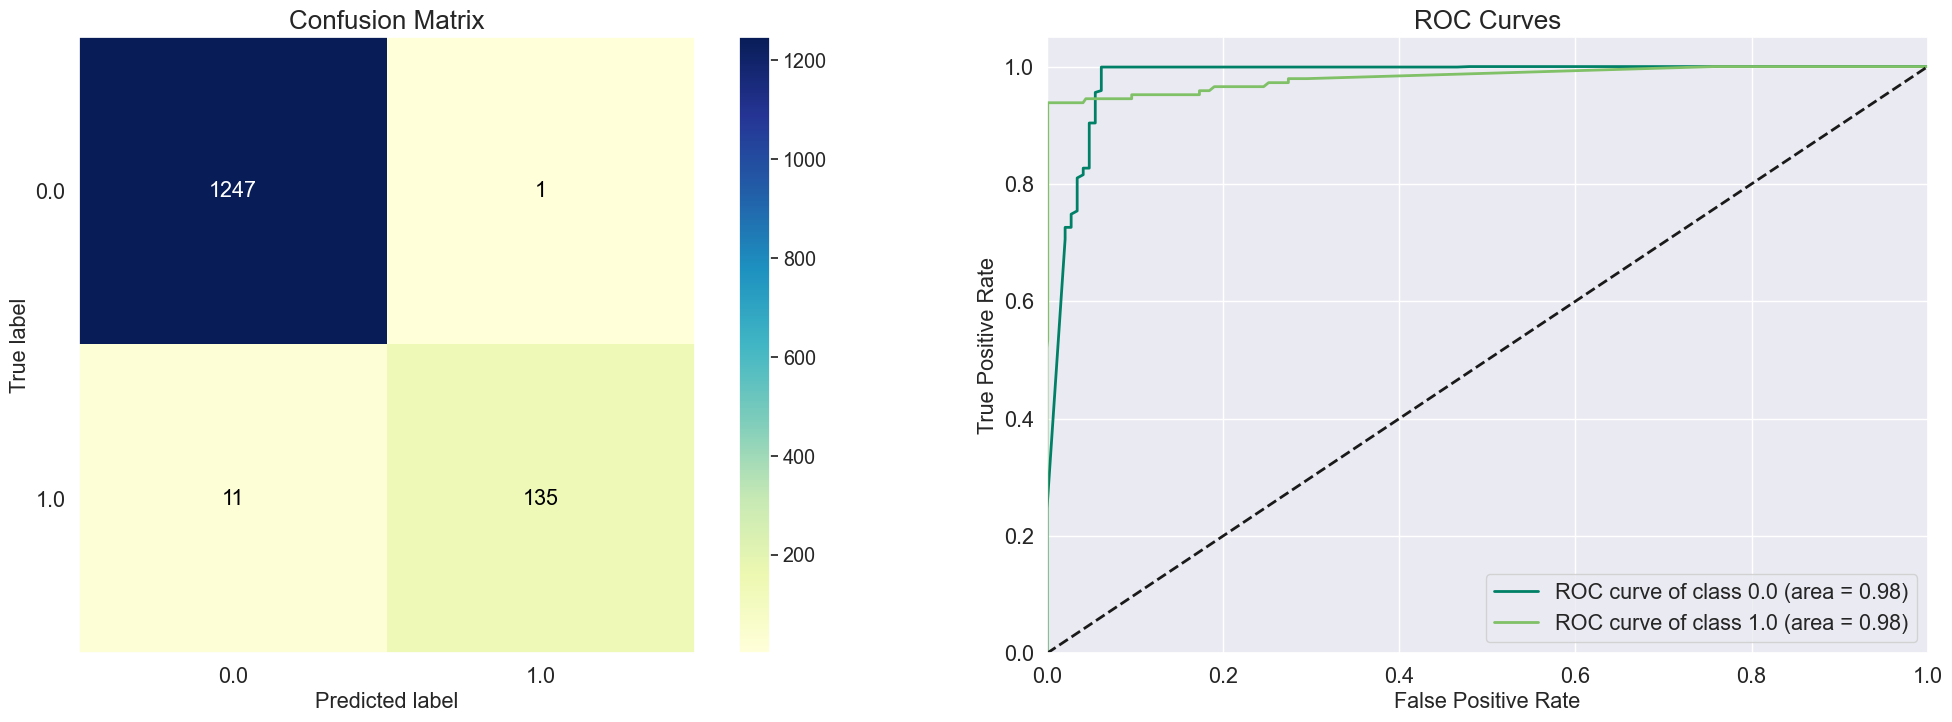

In [87]:
for name,clf in clfs.items():
    print(f'Name :- {name}')
    train_model(clf)